In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from matplotlib import colors as mcolors
%matplotlib inline

# Считывание выборки из файла и нормализация

path - путь до файла с выборкой

Выборка задается в следующем формате:
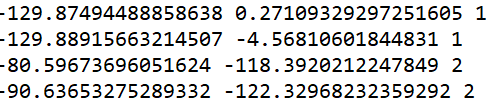
В каждой строке вводится по 1-ому вектору, описывающему один объект. Первые n - 1 (n - число признаков) значений - значения признаков, затем номер класса, к которому объект принадлежит.

In [2]:
def read(path):
    f = open(path)
    points = []
    mx = 0
    mn = 1000000
    for line in f:
        s = ''
        p = []
        for i in range(len(line) - 1):
            if (line[i] == ' '):
                p.append(float(s))
                mx = max(mx, abs(float(s)))
                mn = min(mn, float(s))
                s = ''
            else:
                s += line[i]
        p.append(float(s))
        points.append(p)
    for i in range(len(points)):
        for j in range(len(points[i]) - 1):
            points[i][j] = (points[i][j] - mn) / (mx - mn)
    return points

### Деление выборки на обучающую, тестовую и валидационную

points - набор входных объектов

prop_train - доля объектов в обучающей выборке

prop_valid - доля объектов в валидационной выборке

(1 - prop_valid - prop_train) - доля объектов в тестовой выборке

In [3]:
def sample_split(points, prop_train, prop_valid):
    random.shuffle(points)
    return points[:int(len(points) * prop_train)], points[int(len(points) * prop_train):int(len(points) * (prop_train + prop_valid))], points[int(len(points) * (prop_train + prop_valid)):]

# Функции активации и их производные

Для всех слоев, кроме выходного, в качестве функции активации была выбрана ReLU. Для выходного слоя была выбрана функция активации softmax, которая часто используется в задачах классификации, когда количество классов > 2. Softmax превращает вектор действительных чисел в вектор вероятностей принадлежности классам. Так как в числителе стоит экспонента, большее значение softmax для i-го элемента будет давать намного большую вероятность, чем остальные значения. Также плюс softmax в том, что сумма всех вероятностей = 1 (это позволяет распространять ошибку более выгодно).

In [4]:
def relu(x):
    return x * (x > 0)

def derRelu(x):
    return 1 * (x > 0)

def softmax(arr):
    exps = np.exp(arr - np.max(arr))
    return exps / np.sum(exps)

def derSoftmax(arr):
    return np.diag(arr) - np.outer(arr, arr)

# Персептрон

### __init__(self, n_features, n_classes, layers, learning_rate = 0.01)

n_features - число признаков

n_classes - число классов

layers - массив размеров скрытых слоев (длина массива = число скрытых слоев, layers[i] - число нейронов в i-ом слое)

learning_rate - скорость обучения, по умолчанию = 0.01

Функция создает персептрон с len(layers) + 2 слоев (к скрытым слоям добавляем входной и выходной). Входной слой имеет n_features + 1 нейронов (+1 - так как последний нейрон отвечает за смещение). Скрытые слои имеют по layers[i] + 1 нейронов (+1 по той же причине). Выходной слой имеет n_classes нейронов - если выходной сигнал в i-ом нейроне выходного слоя имеет максимальное значение из всех выходных сигналов в нем, то сеть считает, что объект принадлежит к i-ому классу.

weights - массив весов. weights[i][j][g] означает величину веса между j-ым нейроном i-го слоя и g-ым нейроном i+1-го слоя. Каждый нейрон из слоя i соединяется с каждым нейроном из слоя i + 1, кроме последнего, так как последний нейрон отвечает за смещение, а смещению на вход всегда подается единица, изменяются только веса, выходящие из него.

val - значения выходных сигналов. val[i][j] означает, что выходной сигнал j-ого нейрона i-го слоя на последней итерации имел значение = val[i][j]. Этот массив можно было не создавать внутри конструктора, но пришлось бы заново его объявлять при каждой итерации, так что было решено сделать так.

При инициализации персептрона веса заполняются случайными значениями в диапазоне от -0.5 до 0.5.

### calcOutSignals(self, point)

point - объект, подающийся на вход персептрону

Функция производит расчет выходных сигналов нейронов, идя от входного слоя к выходному. Каждый нейрон, кроме нейронов входного слоя, имеет столько входов, сколько нейронов находится в предыдущем слое. Выходом i-го нейрона является функция активации от взвешенной суммы значений всех входящих в него сигналов. Для скрытых слоев функция активации - сигмоида, для выходного слоя - softmax.

### backProp(self, grad)

grad - градиент

Функция реализует обратное распространение ошибки (подробнее в отчете).

### go(self, point)

point - объект, подающийся на вход персептрону

Функция прогоняет поданный на вход объект по сети, считает градиент и запускает обратное распространение ошибки.

### check(self, point)

point - объект, подающийся на вход персептрону

Функция возвращает номер класса, к которому принадлежит поданный на вход объект.

### train(self, train_sample, valid_sample, eras)

train_sample - обучающее множество

valid_sample - валидационное множество

eras - число эпох обучения

Функция делит множество входных данных на обучающее и тестовое и запускает обучение сети на обучающей выборке. Также после каждой эпохи вызывает метод Accuracy отдельно по обучающей и отдельно по тестовой выборкам.

### accuracy(self, points)

points - выборка объектов

Функция возвращает "точность" сети. Точность вычисляется как (количество верных предсказаний / количестве элементов в поданной выборке). Во время обучения на вход подается валидационное множество.

In [5]:
class Perceptron(object):
    
    def __init__(self, n_features, n_classes, layers, learning_rate = 0.01):
        self.weights = [0] * (len(layers) + 1)
        self.val = [0] * (len(layers) + 2)
        self.weights[0] = [0] * (n_features + 1)
        self.val[0] = [0] * (n_features + 1)
        self.val[len(layers) + 1] = [0] * n_classes
        self.learning_rate = learning_rate
        for i in range(len(layers)):
            self.weights[i + 1] = [0] * (layers[i] + 1)
            self.val[i + 1] = [0] * (layers[i] + 1)
        for i in range(len(layers)):
            for j in range(len(self.weights[i])):
                self.weights[i][j] = [0] * (len(self.weights[i + 1]) - 1)
        for i in range(len(self.weights[len(layers)])):
            self.weights[len(layers)][i] = [0] * n_classes
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                for g in range(len(self.weights[i][j])):
                    self.weights[i][j][g] = random.randint(-1000, 1000) / 2000
        for i in range(len(layers) + 1):
            self.val[i][len(self.val[i]) - 1] = 1

    def backProp(self, grad):
        sig = [0] * len(self.val)
        for i in range(len(self.val)):
            sig[i] = [0] * len(self.val[i])
        sig[len(self.val) - 1] = np.dot(derSoftmax(self.val[len(self.val) - 1]), grad)
        for i in range(len(self.val) - 2, -1, -1):
            for j in range(len(self.val[i])):
                for k in range(len(self.val[i + 1]) - (i + 2 != len(self.val))):
                    sig[i][j] += sig[i + 1][k] * self.weights[i][j][k]
                sig[i][j] *= derRelu(self.val[i][j])
                for k in range(len(self.val[i + 1]) - 1):
                    self.weights[i][j][k] += sig[i + 1][k] * self.learning_rate * self.val[i][j]
            
    def calcOutSignals(self, point):
        for i in range(len(point) - 1):
            self.val[0][i] = point[i]
        for i in range(len(self.weights)):
            for k in range(len(self.val[i + 1]) - 1):
                self.val[i + 1][k] = 0
            for j in range(len(self.weights[i])):
                for g in range(len(self.weights[i][j])):
                    self.val[i + 1][g] += self.val[i][j] * self.weights[i][j][g]
        for i in range(len(self.val) - 1):
            for j in range(len(self.val[i]) - 1):
                self.val[i][j] = relu(self.val[i][j])
        self.val[len(self.val) - 1] = softmax(self.val[len(self.val) - 1])
            
    def go(self, point):
        self.calcOutSignals(point)
        need = [0] * len(self.val[len(self.val) - 1])
        need[int(point[len(point) - 1])] = 1
        grad = [need[i] - self.val[len(self.val) - 1][i] for i in range(len(need))]
        self.backProp(grad)
       
    def check(self, point):
        self.calcOutSignals(point)
        return np.argmax(self.val[len(self.val) - 1])
    
    def accuracy(self, points):
        true = 0
        for i in points:
            if (i[len(i) - 1] == self.check(i)):
                true += 1
        return true / len(points)
    
    def train(self, train_sample, valid_sample, eras):
        acc_train = []
        acc_valid = []
        prev = [self.weights[i] for i in range(len(self.weights))]
        for i in range(eras):
            print('ERA: ' + str(i))
            random.shuffle(train_sample)
            for p in range(len(train_sample)):
                self.go(train_sample[p])
            acc_train.append(self.accuracy(train_sample))
            acc_valid.append(self.accuracy(valid_sample))
            if (i > 0 and (acc_train[i - 1] + acc_valid[i - 1] > acc_train[i] + acc_valid[i])):
                self.weights = [prev[t] for t in range(len(self.weights))]
                acc_train[i] = acc_train[i - 1]
                acc_valid[i] = acc_valid[i - 1]
            plt.figure()
            for t in range(len(acc_train) - 1):
                x1, y1 = [t + 1, t + 2], [acc_train[t], acc_train[t + 1]]
                plt.plot(x1, y1, marker = 'o', color = 'Blue')
                x1, y1 = [t + 1, t + 2], [acc_valid[t], acc_valid[t + 1]]
                plt.plot(x1, y1, marker = 'o', color = 'Green')
            plt.show()
        return acc_train, acc_valid

# Задаем начальные параметры

In [6]:
filename = 'tests/test3.txt' # имя файла
n_features = 2 # число признаков
n_classes = 3 # число классов
layers = [2] # массив слоев персептрона
learning_rate = 0.05 # скорость обучения
p1 = 0.6 # доля обучающей выборки от всего набора данных
p2 = 0.2 # доля валидационной выборки от всего набора данных
eras = 20 # число эпох

# Считываем выборку, делим ее на обучающее, валидационное и тестовое множества, создаем экземпляр класса Персептрон и запускаем обучение.

ERA: 0


<Figure size 432x288 with 0 Axes>

ERA: 1


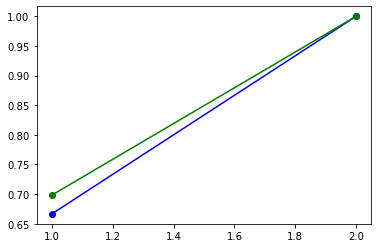

ERA: 2


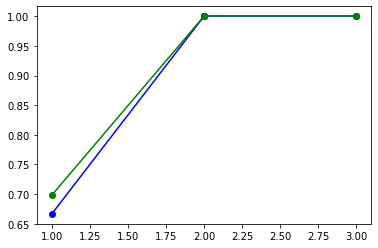

ERA: 3


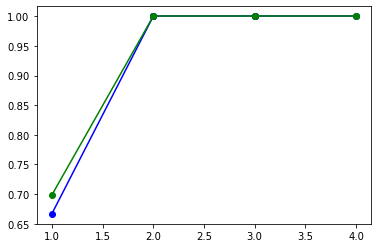

ERA: 4


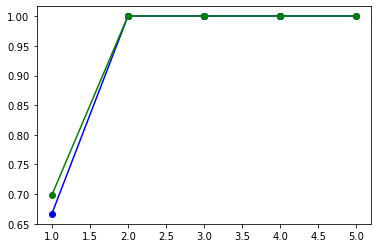

ERA: 5


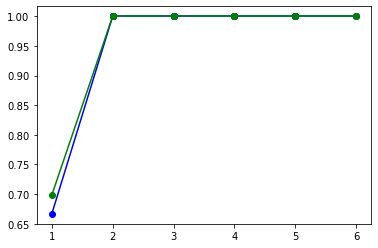

ERA: 6


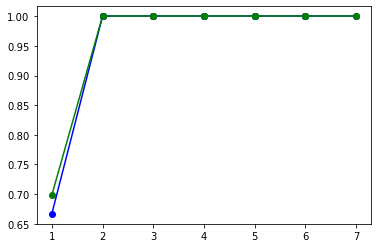

ERA: 7


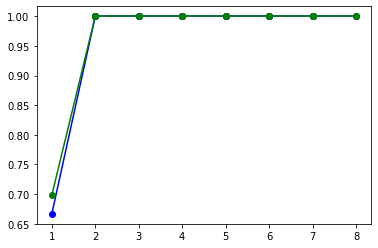

ERA: 8


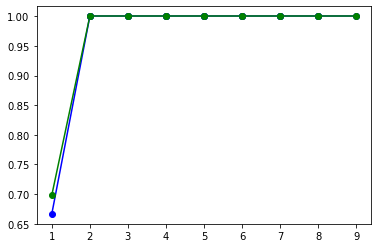

ERA: 9


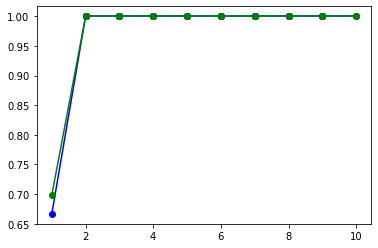

ERA: 10


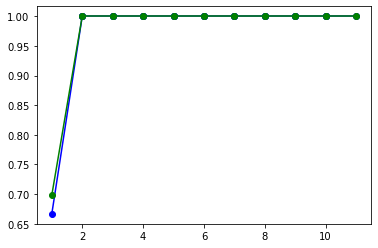

ERA: 11


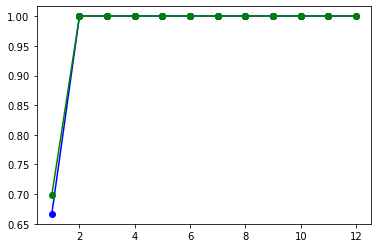

ERA: 12


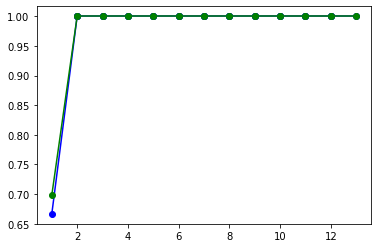

ERA: 13


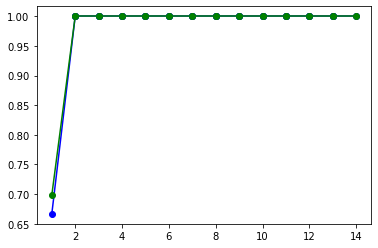

ERA: 14


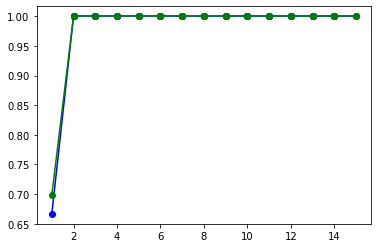

ERA: 15


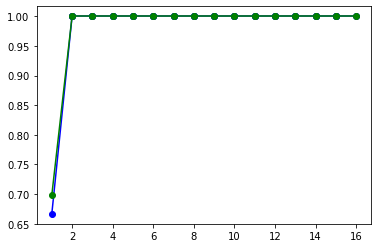

ERA: 16


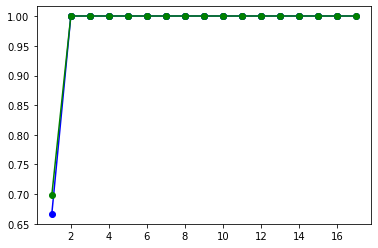

ERA: 17


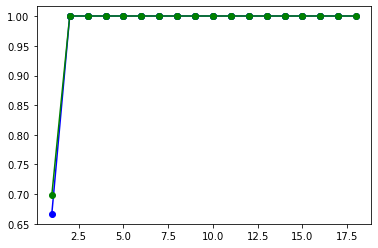

ERA: 18


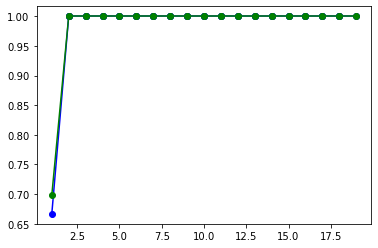

ERA: 19


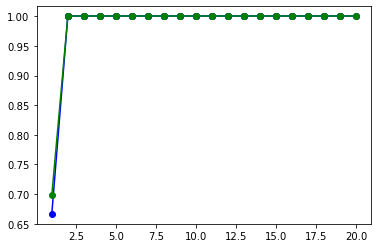

In [7]:
points = read(filename)
train_sample, valid_sample, test_sample = sample_split(points, p1, p2)
a = Perceptron(n_features, n_classes, layers, learning_rate)
acc_train, acc_valid = a.train(train_sample, valid_sample, eras)

# Выводим Accuracy

Синяя линия - точность на обучающем множестве

Зеленая линия - точность на валидационном множестве

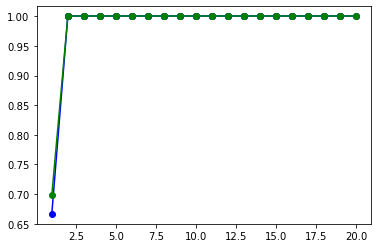

In [8]:
plt.figure()
for i in range(len(acc_train) - 1):
    x1, y1 = [i + 1, i + 2], [acc_train[i], acc_train[i + 1]]
    plt.plot(x1, y1, marker = 'o', color = 'Blue')
    x1, y1 = [i + 1, i + 2], [acc_valid[i], acc_valid[i + 1]]
    plt.plot(x1, y1, marker = 'o', color = 'Green')
plt.show()

# Выводим полученное разделение на классы на картинке

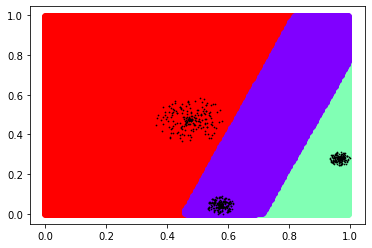

In [9]:
res_classes = [0] * n_classes
res_x = [0] * n_classes
res_y = [0] * n_classes
for i in range(n_classes):
    res_x[i] = [0] * 1
    res_y[i] = [0] * 1
for i in np.arange(0.0, 1.0, 0.005):
    for j in np.arange(0.0, 1.0, 0.005):
        t = a.check([i, j, 0])
        res_x[t].append(i)
        res_y[t].append(j)
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, n_classes))
j = 0
step = 3
if (n_classes % 3 == 0):
    step = 5
if (n_classes % 3 == 0 and n_classes % 5 == 0):
    step = 7
for i in range(n_classes):
    del res_x[i][0]
    del res_y[i][0]
    j = (j + step) % n_classes
    plt.scatter(res_x[i], res_y[i], color = colors[j])
points = test_sample
for i in range(40):
    _x = [points[j][0] for j in range(len(points)) if (points[j][2] == i)]
    _y = [points[j][1] for j in range(len(points)) if (points[j][2] == i)]
    plt.scatter(_x, _y, s = 0.5, color = 'Black')
plt.show()